In [8]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import os

In [ ]:
train_dir = "data/chest_xray/train"
test_dir = "data/chest_xray/test"
val_dir = "data/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("data/chest_xray/train/PNEUMONIA")
pneumonia_dir = "data/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


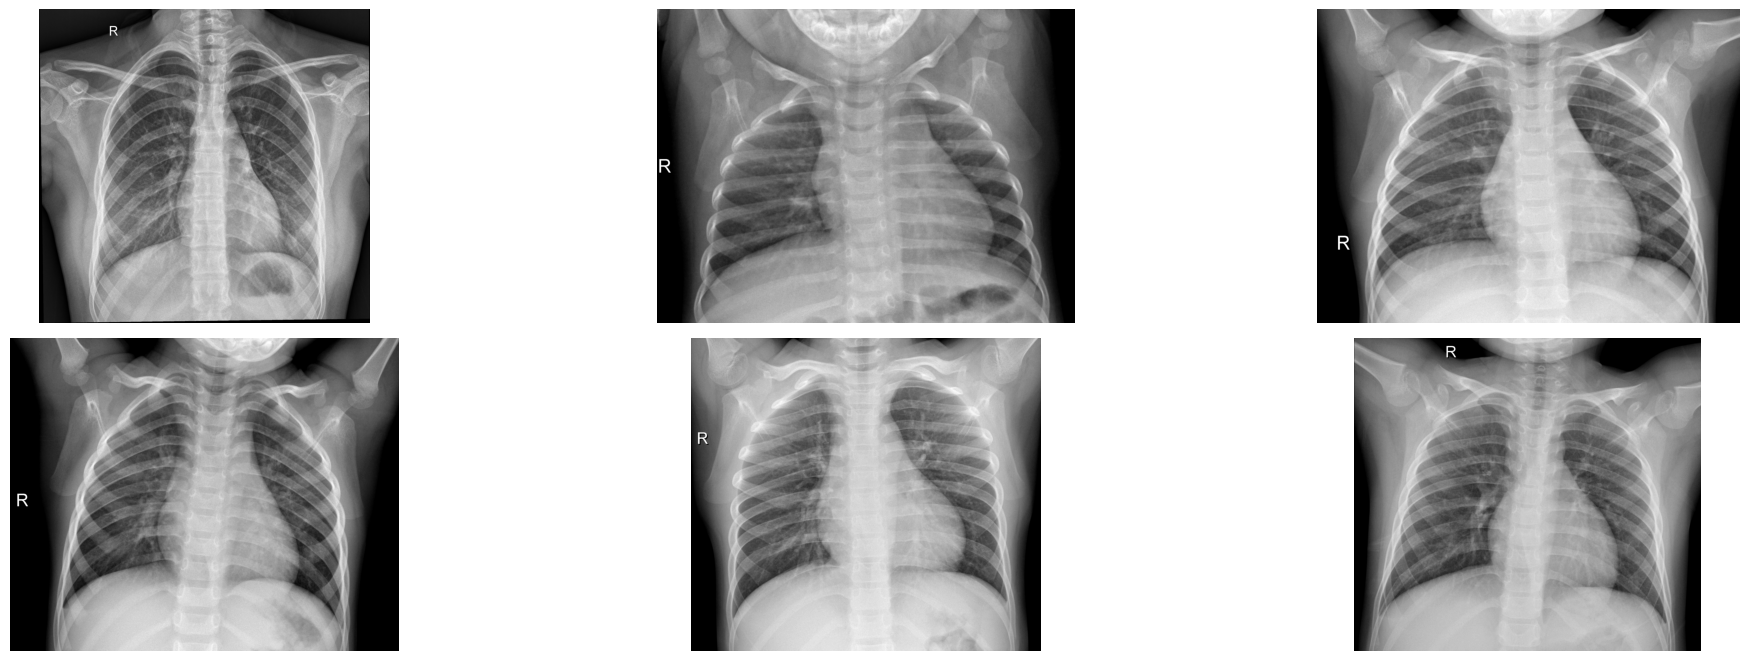

In [92]:
normal = os.listdir("data/chest_xray/train/NORMAL")
normal_dir = "data/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

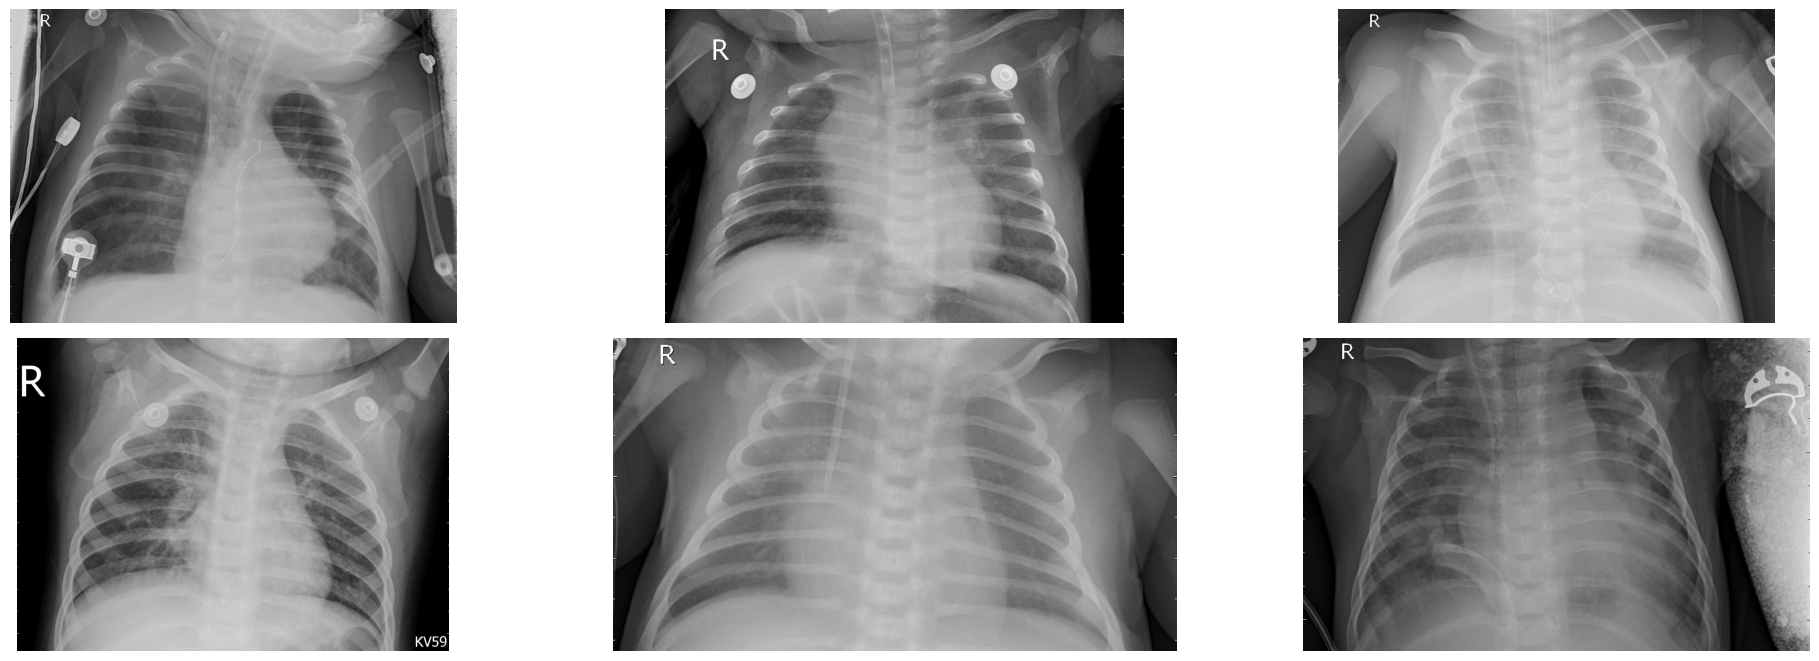

In [93]:
pneumonia = os.listdir("data/chest_xray/train/PNEUMONIA")
pneumonia_dir = "data/chest_xray/train/PNEUMONIA"
plt.figure(figsize=(20, 10))

for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]), )
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

The dimensions of the image are 2234 pixels width and 2359 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 124.3910 and the standard deviation is 56.3308


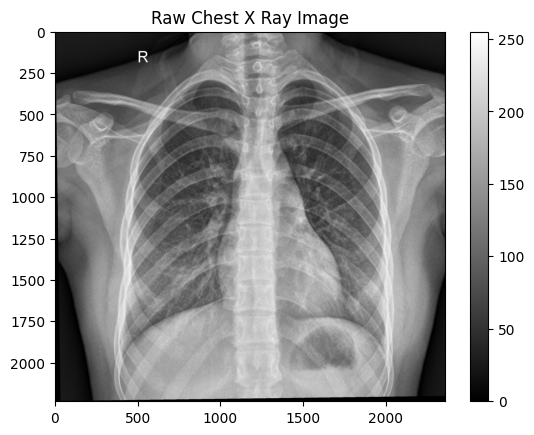

In [11]:
normal_img = os.listdir("data/chest_xray/train/NORMAL")[0]
normal_dir = "data/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

In [12]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [101]:
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            color_mode='grayscale',
                                            target_size=(128, 128))

validation = image_generator.flow_from_directory(val_dir,
                                                 batch_size=1,
                                                 shuffle=False,
                                                 class_mode='binary',
                                                 color_mode='grayscale',
                                                 target_size=(128, 128))

test = image_generator.flow_from_directory(test_dir,
                                           batch_size=1,
                                           shuffle=False,
                                           class_mode='binary',
                                           color_mode='grayscale',
                                           target_size=(128, 128))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


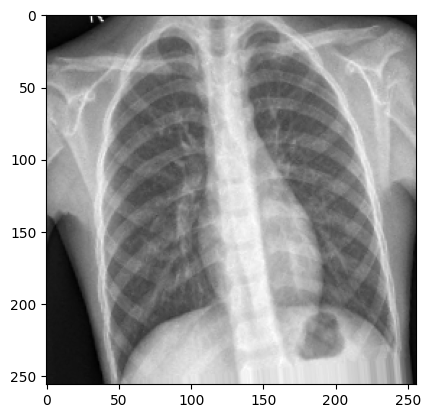

In [97]:
img, label = test.next() #  (1,256,256,3)
plt.imshow(img[0], cmap='gray')
plt.show()

In [50]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [57]:
class ConvolutionalTokenizer(layers.Layer):
    """
    Creates Convolutional Tokens of images for feeding to Transformer Encoder.
    """
    def __init__(self,kernel_size=3,stride=1,padding=1,pooling_kernel_size=3,pooling_stride=2,conv_layers=2,num_output_channels=[64, 128],**kwargs,):
        super(ConvolutionalTokenizer, self).__init__(**kwargs)

        # Creating a Sequential Keras Model for Tokenizing images
        self.conv_model = keras.Sequential()
        # Created the required number of convolutional layer
        for i in range(conv_layers):
            # Adding a conv2d layer with ReLU activation as suggested by authors
            self.conv_model.add(layers.Conv2D(num_output_channels[i],kernel_size,stride,padding="valid",use_bias=False,activation="relu",kernel_initializer="he_normal"))
            # Zero Padding
            self.conv_model.add(layers.ZeroPadding2D(padding))
            # Pooling over the image with 3x3 kernel having padding='same' and stride=2
            self.conv_model.add(layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))

    def call(self, images):
        # Reshaping the outputs by flattening them
        outputs = self.conv_model(images)
        Flattened = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[3]),
        )
        return Flattened

    # Adding Learnable Positional Embeddings
    def pos_embeddings(self, image_size):
        inp = tf.ones((1, image_size, image_size, 1))
        out = self.call(inp)
        seq_len = tf.shape(out)[1]
        projection_dim = tf.shape(out)[-1]

        embed_layer = layers.Embedding(
            input_dim=seq_len, output_dim=projection_dim
        )
        return embed_layer, seq_len

In [58]:
def mlp(x, hidden_units, dropout):
    """
    Creates A Feed Forward Network`

    Args:
        hidden_units: Number of hidden units in MLP
        dropout: The Rate of dropout which is to be applied.
    """
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout)(x)
    return x

In [59]:
def Transformer_Encoder(L,embedded_patches,num_heads,projection_dim,transformer_units):
    """
    Transformer Encoder Block

    Args:
        L: number of transformer_layers

        embedded_patches: Patches from the Convolutional Tokenizer block

        num_heads: Number of Attention Heads

        projection_dim: Size of each attention head for query and key

        transformer_units: hidden units of MLP
    """


    # Iterating over the number of transformer layers
    for i in range(L):
        # Normalizing the input patches
        norm = layers.LayerNormalization(epsilon=1e-5)(embedded_patches)
        # Feeding to MHA
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(norm,norm)
        # Shortcut skip connection
        skip1 = layers.Add()([attention_output, embedded_patches])
        # Normalizing
        norm2= layers.LayerNormalization(epsilon=1e-5)(skip1)

        # Feed Forward MLP
        ffn = mlp(norm2, hidden_units=transformer_units, dropout=0.1)

        # Shortcut skip connection
        embedded_patches = layers.Add()([ffn, skip1])

        return embedded_patches

In [60]:
def SeqPool(trans_enco_out):
    """
    Sequence Pooling block.

    Args:
        trans_enco_out: Takes in the Output of transformer encoder block

    Returns:
        A 1xD output to be fed to final classifier
    """
    # Normalizing the output of transformer enocder layer
    normalized = layers.LayerNormalization(epsilon=1e-5)(trans_enco_out)
    # Adding a linear layer
    linear=layers.Dense(1)(normalized)
    # Applying Softmax to the linear layer
    soft = tf.nn.softmax(linear, axis=1)
    # Multiplying the softmax of linear layer with the normalized output of orignal output of the transformer encoder block
    mult = tf.matmul(soft, normalized, transpose_a=True)
    # Squeezing the dimensions
    seq_pool_output = tf.squeeze(mult, -2)

    return seq_pool_output

In [102]:
def CompactConvolutionalTransformer(image_size=128,num_classes=2,input_shape=(128, 128, 1),projection_dim=128,num_heads=2,L=2,transformer_units=[128,128]):
    """
    CCT model

    Args:
        image_size: size of image

        num_classes: Number of classes of output

        input_shape: shape of image

        projection_dim: Size of each attention head for query and key

        num_heads: Number of heads of MHA

        L: Number of transformer encoder layers

    Returns:
        CCT Model
    """

    inputs = layers.Input(input_shape)
    """
    Convolutional Tokenization Block as shown in above image
    """
    # Encode patches.
    conv_tokenizer = ConvolutionalTokenizer()
    embedded_patches = conv_tokenizer(inputs)

    # Adding positional embedding.
    pos_embed, seq_length = conv_tokenizer.pos_embeddings(image_size)
    positions = tf.range(start=0, limit=seq_length, delta=1)
    position_embeddings = pos_embed(positions)
    embedded_patches += position_embeddings


    """
    Transformer with Sequence Pooling Block as shown in above image
    """

    # Feeding embedded patches after adding embeddings to transformer encoder block
    embedded_patches=Transformer_Encoder(L,embedded_patches,num_heads=num_heads,projection_dim=projection_dim,transformer_units=transformer_units)

    # Applying sequence pooling to output of the transformer encoder block
    sequence_pooling=SeqPool(embedded_patches)

    # Adding a dense layer for predictions
    output= layers.Dense(num_classes,activation='softmax')(sequence_pooling)

    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [103]:
CompactConvolutionalTransformer().summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 convolutional_tokenizer_15 (Co  (None, 1024, 128)   74304       ['input_16[0][0]']               
 nvolutionalTokenizer)                                                                            
                                                                                                  
 tf.__operators__.add_14 (TFOpL  (None, 1024, 128)   0           ['convolutional_tokenizer_15[0][0
 ambda)                                                          ]']                       

In [105]:
# Instantiating our CCT model
cct_model = CompactConvolutionalTransformer()
# Compiling our Model
cct_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
# Training model for 50 epochs
history = cct_model.fit(
    train,
    class_weight=class_weight,
    epochs=15,
    validation_data=validation
)

Epoch 1/15
652/652 [==============================] - 134s 204ms/step - loss: 0.1844 - accuracy: 0.7632 - val_loss: 1.0640 - val_accuracy: 0.5625
Epoch 2/15
652/652 [==============================] - 127s 195ms/step - loss: 0.1324 - accuracy: 0.8562 - val_loss: 1.1811 - val_accuracy: 0.6250
Epoch 3/15
652/652 [==============================] - 127s 195ms/step - loss: 0.1218 - accuracy: 0.8652 - val_loss: 1.0459 - val_accuracy: 0.5625
Epoch 4/15
652/652 [==============================] - 128s 196ms/step - loss: 0.1148 - accuracy: 0.8754 - val_loss: 1.2455 - val_accuracy: 0.6250
Epoch 5/15
652/652 [==============================] - 132s 202ms/step - loss: 0.1133 - accuracy: 0.8756 - val_loss: 1.0631 - val_accuracy: 0.6875
Epoch 6/15
652/652 [==============================] - 128s 197ms/step - loss: 0.1114 - accuracy: 0.8790 - val_loss: 1.0198 - val_accuracy: 0.6875
Epoch 7/15
652/652 [==============================] - 124s 191ms/step - loss: 0.1100 - accuracy: 0.8750 - val_loss: 1.2839 -

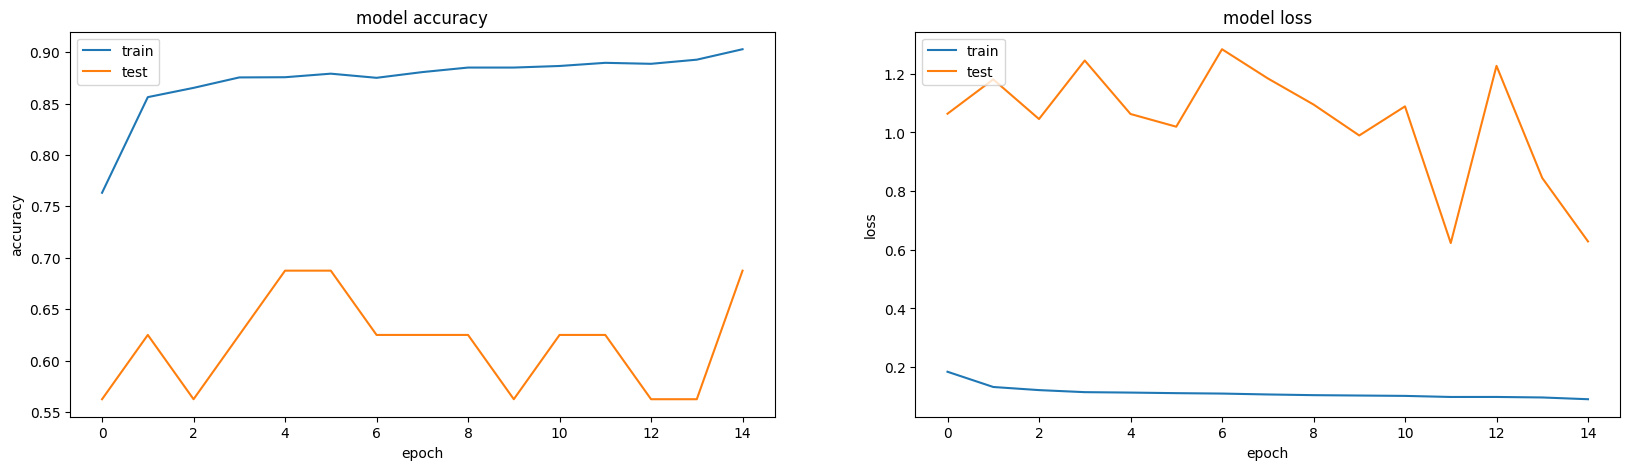

In [106]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [107]:
evaluation = cct_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = cct_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 17s 27ms/step - loss: 0.3156 - accuracy: 0.8606
Test Accuracy: 86.06%
652/652 [==============================] - 63s 96ms/step - loss: 0.2412 - accuracy: 0.9030
Train Accuracy: 90.30%


In [108]:
predicted_vals = cct_model.predict(test, steps=len(test))

624/624 [==============================] - 17s 26ms/step


In [119]:
predicted_categories = np.argmax(predicted_vals, axis = 1)

In [121]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(confusion_matrix(test.classes, predicted_categories))
pd.DataFrame(classification_report(test.classes, predicted_categories, output_dict=True))

[[187  47]
 [ 33 357]]


,0,1,accuracy,macro avg,weighted avg
precision,0.850000,0.883663,0.871795,0.866832,0.871040
recall,0.799145,0.915385,0.871795,0.857265,0.871795
f1-score,0.823789,0.899244,0.871795,0.861516,0.870948
support,234.000000,390.000000,0.871795,624.000000,624.000000
